In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
df_data = pd.read_csv('multi_column_MEISD.csv')

In [3]:
df_data

,Utterances,sentiment,combined_emotions,combined_intensities
0,look around you,2,[0],[]
1,say hello to your competition,2,[0],[]
2,eight of you will switch to an easier specialty,2,[0],[]
3,five of you will crack under the pressure,2,[0],[]
4,two of you will be asked to leave,2,[0],[]
...,...,...,...,...
20012,"oh, that's right, you're a woman and you need ...",0,"[6, 2]","[1, 2]"
20013,i'll try again,0,"[6, 2]","[1, 2]"
20014,"please, pam, reconsider and have a bagel",0,"[1, 2]",[1]
20015,i have an early lunch,0,"[6, 2]","[1, 2]"


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_emotions = MultiLabelBinarizer()
binary_emotions = mlb_emotions.fit_transform(df_data['combined_emotions'])

mlb_intensities = MultiLabelBinarizer()
binary_intensities = mlb_intensities.fit_transform(df_data['combined_intensities'])

from sklearn.preprocessing import LabelEncoder
le_sentiment = LabelEncoder()
encoded_sentiment = le_sentiment.fit_transform(df_data['sentiment'])

df_emotions = pd.DataFrame(binary_emotions, columns=[f"emotion_{i}" for i in range(binary_emotions.shape[1])])
df_intensities = pd.DataFrame(binary_intensities, columns=[f"intensity_{i}" for i in range(binary_intensities.shape[1])])
df_sentiment = pd.DataFrame(encoded_sentiment, columns=['sentiment'])

df = pd.concat([df_data['Utterances'], df_emotions, df_intensities, df_sentiment], axis=1)


In [5]:
print(binary_emotions)

[[0 0 1 ... 0 1 1]
 [0 0 1 ... 0 1 1]
 [0 0 1 ... 0 1 1]
 ...
 [1 1 0 ... 0 1 1]
 [1 1 0 ... 0 1 1]
 [0 0 0 ... 0 1 1]]


In [6]:
df

,Utterances,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,...,emotion_11,emotion_12,intensity_0,intensity_1,intensity_2,intensity_3,intensity_4,intensity_5,intensity_6,sentiment
0,look around you,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,2
1,say hello to your competition,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,2
2,eight of you will switch to an easier specialty,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,2
3,five of you will crack under the pressure,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,2
4,two of you will be asked to leave,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20012,"oh, that's right, you're a woman and you need ...",1,1,0,0,1,0,0,0,1,...,1,1,1,1,1,1,0,1,1,0
20013,i'll try again,1,1,0,0,1,0,0,0,1,...,1,1,1,1,1,1,0,1,1,0
20014,"please, pam, reconsider and have a bagel",1,1,0,1,1,0,0,0,0,...,1,1,0,0,1,0,0,1,1,0
20015,i have an early lunch,1,1,0,0,1,0,0,0,1,...,1,1,1,1,1,1,0,1,1,0


In [7]:
columns = df.columns
categor_freq = df[columns[2:]].sum()/df.shape[0]
categor_freq

emotion_1      0.421092
emotion_2      0.166359
emotion_3      0.148174
emotion_4      0.299146
emotion_5      0.109107
emotion_6      0.197182
emotion_7      0.180397
emotion_8      0.180996
emotion_9      0.023280
emotion_10     0.056052
emotion_11     1.000000
emotion_12     1.000000
intensity_0    0.313034
intensity_1    0.313034
intensity_2    0.499775
intensity_3    0.427537
intensity_4    0.207923
intensity_5    1.000000
intensity_6    1.000000
sentiment      1.405455
dtype: float64

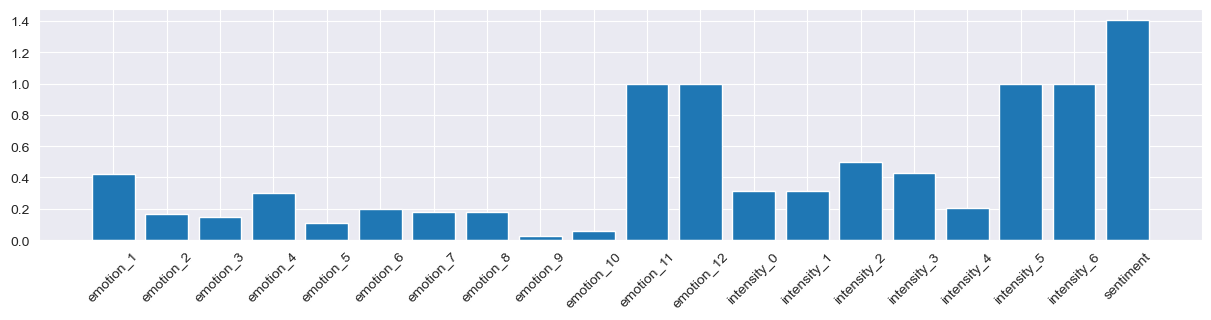

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)
plt.bar(categor_freq.index, categor_freq.values)
_ = plt.xticks(rotation = 45)

In [9]:
# Drop the categories with low frequencies
signif_cols = categor_freq.index[categor_freq.values>0.05]
df0 = df[['Utterances']+list(signif_cols)]
# Remove articles with zeros in all the categories
df0 = df0.loc[df0[signif_cols].sum(axis=1)>0]
df0.head(4)

,Utterances,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8,emotion_10,emotion_11,emotion_12,intensity_0,intensity_1,intensity_2,intensity_3,intensity_4,intensity_5,intensity_6,sentiment
0,look around you,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,2
1,say hello to your competition,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,2
2,eight of you will switch to an easier specialty,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,2
3,five of you will crack under the pressure,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,2


In [10]:
df0.shape


(20017, 20)

In [ ]:
df0 = df0.sample(n = 10_000, random_state = 4)


In [12]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df0, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df0, random_state=88, test_size=0.50, shuffle=True)


In [13]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")


Train: (14011, 20), Test: (10008, 20), Valid: (10009, 20)


In [32]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid


In [16]:
from transformers import BertTokenizer, BertModel


In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


D:\conda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [19]:
df_train['Utterances']


13858                  had you asked a couple of weeks ago
14789                                       Yeah! Richard!
17589              young benjamin here knows what's coming
8549     i don't see why they had to keep my credit car...
18378                                           between us
                               ...                        
7832     I imagine it's difficult adjusting to the new ...
9509      yesterday, barney thought he had to say good-bye
18667               yeah, right? i'm so glad you said that
8799             okay, i'm gonna stop you right there, ted
15063     This is Bonnie?  This is Bonnie?  Youre Bonnie?
Name: Utterances, Length: 14011, dtype: object

In [20]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])
        utterances = " ".join(utterances.split())
        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'utterances': utterances
        }


In [21]:
target_list = list(df0.columns)
target_list


['Utterances',
 'emotion_1',
 'emotion_2',
 'emotion_3',
 'emotion_4',
 'emotion_5',
 'emotion_6',
 'emotion_7',
 'emotion_8',
 'emotion_10',
 'emotion_11',
 'emotion_12',
 'intensity_0',
 'intensity_1',
 'intensity_2',
 'intensity_3',
 'intensity_4',
 'intensity_5',
 'intensity_6',
 'sentiment']

In [22]:
target_list = target_list[1:]

In [23]:
target_list

['emotion_1',
 'emotion_2',
 'emotion_3',
 'emotion_4',
 'emotion_5',
 'emotion_6',
 'emotion_7',
 'emotion_8',
 'emotion_10',
 'emotion_11',
 'emotion_12',
 'intensity_0',
 'intensity_1',
 'intensity_2',
 'intensity_3',
 'intensity_4',
 'intensity_5',
 'intensity_6',
 'sentiment']

In [24]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)


In [25]:
next(iter(train_dataset))

{'input_ids': tensor([ 101, 2018, 2017, 2356, 1037, 3232, 1997, 3134, 3283,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

In [26]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0
                                                )

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                              batch_size=VALID_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0
                                              )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0
                                               )

In [37]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 19)
        self.sigmoid = nn.Sigmoid()


    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        output = self.sigmoid(output)
        return output

model = BERTClass()

# # Freezing BERT layers:
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [28]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)


In [29]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         


D:\conda\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                   leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)


In [31]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)
     


In [38]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc
     


Epoch 1/3


  0%|          | 0/438 [00:00<?, ?it/s]

train_loss=0.7395, val_loss=0.7385 train_acc=0.4065, val_acc=0.4072
Epoch 2/3


  0%|          | 0/438 [00:00<?, ?it/s]

train_loss=0.7396, val_loss=0.7385 train_acc=0.4065, val_acc=0.4072
Epoch 3/3


  0%|          | 0/438 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()
